# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#Update scikit-learn
#!pip install --upgrade scikit-learn

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
from sklearn.preprocessing import StandardScaler
SScale = StandardScaler()
from sklearn.decomposition import PCA
pca = PCA()
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.shape

(85, 4)

In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [11]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_REL,person,ordinal,[-1]
freq,1,43,49,26


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()

4896838

> The number of null values in azdias without manipulation is 4,896,838

In [13]:
for idx in range(len(feat_info)):
    missing_or_unknown = feat_info.at[idx, 'missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[]').split(',')
    missing_or_unknown = [int(value) if (value not in ['X', 'XX', '']) else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias[feat_info.iloc[idx]['attribute']] = azdias[feat_info.iloc[idx]['attribute']].replace(missing_or_unknown, np.nan)

In [14]:
azdias.isnull().sum().sum()

8373929

> The number of null values after manipulating azdias with the "missing_and_unknown" column is 8,373,929 

In [15]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values_percent = (azdias.isnull().sum() / len(azdias)) * 100

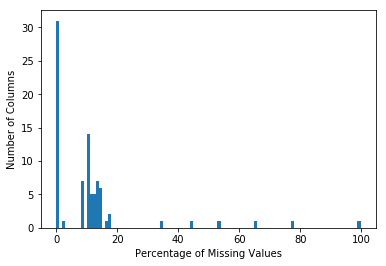

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values_percent, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()

> Most of the columns fall below 30% of missing values, therefore, anything above 30% should be considered outliers.

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Get columns that above 30% missing values
missing_values_percent_30 = missing_values_percent[missing_values_percent>=30]
# Add the columns to a list that will be dropped
drop_columns = missing_values_percent_30.index.tolist()
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [19]:
# Drop the columns that are above 20% missing
azdias = azdias.drop(drop_columns, axis=1)

# Check to see if columns are deleted
azdias.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discussion 1.1.2: Assess Missing Data in Each Column

1) Are there any patterns in missing values?
  - Based off of the graph most columns have less than 30% missing data meaning anything above 30% are the outliers.
  
2) Which columns were removed from the dataset?
  - The columns that were removed are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

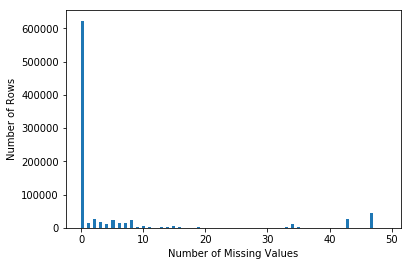

In [20]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

> According to the graph the high tail of the "low-end" seems to be 20 and the low tail of the "high-end" appears to be 30.
> I will split the missing value data into two subsets `30 and below` and `above 30`.

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_per_row_under30 = azdias[azdias.isnull().sum(axis=1) <= 30]
missing_per_row_over30 = azdias[azdias.isnull().sum(axis=1) > 30]

In [22]:
#Create value to hold columns that have 0 missing values
no_missing_columns = missing_values_percent[missing_values_percent == 0].index.tolist()
#Create a compare column value to compare at least 5 columns
compare_columns = no_missing_columns[:6]
compare_columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER']

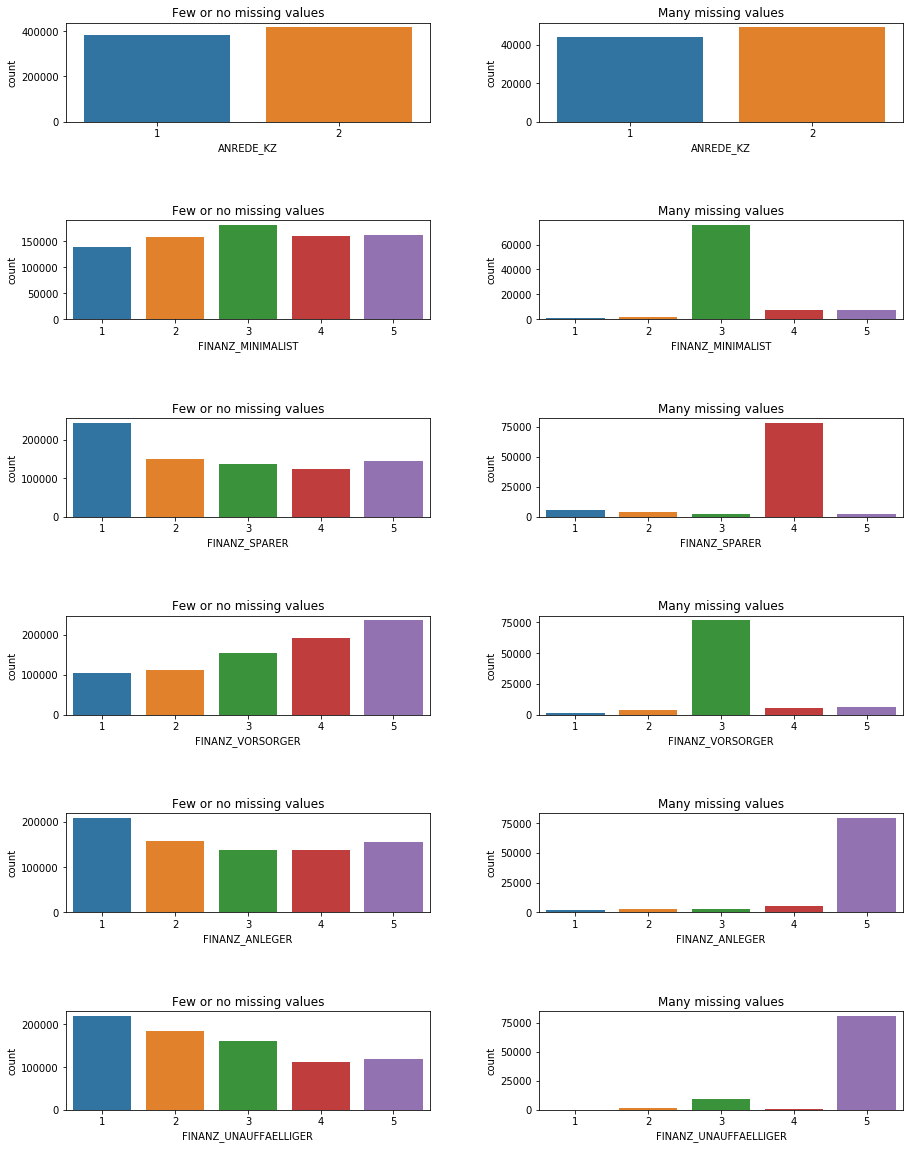

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)

for i in range(len(compare_columns)):
    sns.countplot(missing_per_row_under30[compare_columns[i]], ax=axs[i, 0])
    axs[i, 0].set_title('Few or no missing values')
    sns.countplot(missing_per_row_over30[compare_columns[i]], ax=axs[i, 1])
    axs[i, 1].set_title('Many missing values')

plt.show();

#### Discussion 1.1.3: Assess Missing Data in Each Row
1) Are the data with lots of missing values are qualitatively different from data with few or no missing values?
**Gender**
-  1: male
-  2: female

ANREDE_KZ - The distribution for both 'few or no missing values' and 'many missing values' are simular as shown by both graphs.  

**Finance** : 
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

For the 'few or no missing values' graphs there's not alot of variance in the amount of missing values, however, with the many missing values graphs we can see quite a variance.

For each column:

- FINANZ_MINIMALIST - there are several 'average' values missing.
- FINANZ_SPARER - there are several 'low' values missing.
- FINANZ_VORSORGER - there are several 'average' values missing.
- FINANZ_ANLEGER - there are several 'very low' values missing.
- FINANZ_UNAUFFAELLIGER - there are several 'very low' values missing.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
features = list(azdias.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
data_type_count = feat_info_clean['type'].value_counts()
for data_type, count in data_type_count.items():
    print(f'There are {count} {data_type} features.')

There are 49 ordinal features.
There are 18 categorical features.
There are 6 numeric features.
There are 6 mixed features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_variables = feat_info_clean.loc[feat_info_clean["type"]=="categorical", "attribute"]
cat_variables

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
binary_feature = []
multi_level_feature=[]
for feature in cat_variables:
    if (len(azdias[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(azdias[feature].unique())>2):
        multi_level_feature.append(feature)

In [27]:
binary_feature

['ANREDE_KZ', 'GREEN_AVANTGARDE']

In [28]:
multi_level_feature

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [29]:
#Drop multi-level features
azdias_clean=azdias.drop(columns=multi_level_feature)
#Check to make sure columns were removed
azdias_clean.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discussion 1.2.1: Re-Encode Categorical Features 

Which ones did you keep, which did you drop, and what engineering steps did you perform?

- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
    - The two binary feature columns located are: 'ANREDE_KZ', 'GREEN_AVANTGARDE'. Since both are numeric no changes were needed.


- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis.
    - The multi-level columns that were located are:
        - 'CJT_GESAMTTYP',
        - 'FINANZTYP',
        - 'GFK_URLAUBERTYP'
        - 'LP_FAMILIE_FEIN',
        - 'LP_FAMILIE_GROB',
        - 'LP_STATUS_FEIN', 
        - 'LP_STATUS_GROB', 
        - 'NATIONALITAET_KZ',
        - 'SHOPPER_TYP', 
        - 'SOHO_KZ',
        - 'VERS_TYP',
        - 'ZABEOTYP',
        - 'GEBAEUDETYP',
        - 'OST_WEST_KZ',
        - 'CAMEO_DEUG_2015'
        - 'CAMEO_DEU_2015'
     
    - All of the above multi-level columns were deleted within a copy dataframe called azdias_clean.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
azdias_clean.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
#Confirm 'Decade' and 'movement' columns were created
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,14.0,14.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,15.0,15.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.0,8.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,8.0,8.0


In [32]:
#Create two dictonaries for decade and movement using values found in Data_dictionary
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# Add values to the newly created columns
azdias_clean['DECADE'].replace(decade_dict, inplace=True)
azdias_clean['MOVEMENT'].replace(movement_dict, inplace=True)

#confirm changes
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0


In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean.CAMEO_INTL_2015.value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [34]:
#Create two new columns 'WEALTH' and 'LIFE_STAGE'
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']
#Confirm 'wealth' and 'life_stage' columns were created
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,51,51
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,24,24
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,12,12
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,43,43


In [35]:
#Create two dictonaries for wealth and life_stage using values found in Data_dictionary

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_clean['WEALTH'].replace(wealth_dict, inplace=True)
azdias_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

#confirm changes
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

1) Which ones did you keep, which did you drop, and what engineering steps did you perform?

I Created four new feature columns (2 based off of the column PRAEGENDE_JUGENDJAHRE and 2 based off of CAMEO_INTL_2015). To fill the columns I used the information within the data dictonary to determine the intital values.

**Break down:**

'DECADE': 40s = 1, 50s = 2, 60s = 3, 70s = 4, 80s = 5, and 90s= 6.

'MOVEMENT': 1 = Mainstream, 0 = Avantgarde

'WEALTH': 1 = Wealthy, 2 = Prosperous, 3 = Comfortable, 4 = Less Affluent, 5 = Poorer

'LIFE_STAGE': 1 = Pre-Family Couples & Singles, 2 = Young Couples With Children, 3 = Families With School Age Children, 4 = Older Families &  Mature Couples, 5 = Elders In Retirement

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Create variable for mixed features (6 total)
mixed_feats = feat_info_clean.loc[feat_info_clean["type"]=="mixed", "attribute"]

#Drop mixed feature columns
azdias_clean = azdias_clean.drop(columns=mixed_feats)

#Confirm columns have been deleted
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [37]:
#These are the 6 mixed columns that were removed
mixed_feats

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

> Notice that PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 are on the remove list. Since we created the 4 columns earlier to represent this data, dropping these two columns is acceptable and encouraged.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for idx in range(len(feat_info)):
        missing_or_unknown = feat_info.at[idx, 'missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[]').split(',')
        missing_or_unknown = [int(value) if (value not in ['X', 'XX', '']) else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df[feat_info.iloc[idx]['attribute']] = df[feat_info.iloc[idx]['attribute']].replace(missing_or_unknown, np.nan)
    
    # remove selected columns and rows, ...
    
    # Drop the columns that are above 30% missing
    df_clean = df.drop(drop_columns, axis=1)
    
    #Clean multi level features
    df_clean = df_clean.drop(columns=multi_level_feature, axis=1)
    
    # select, re-encode, and engineer column values.
    
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    #Drop Mixed Features
    df_clean = df_clean.drop(mixed_feats, axis=1)
       
    # Return the cleaned dataframe.
    
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [39]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean_imputed = pd.DataFrame(imp_mf.fit_transform(azdias_clean))
azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index
azdias_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,...,0.0,3.0,3.0,4.0,5.0,3.0,6.0,1.0,5.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0


In [40]:
# Apply feature scaling to the general population demographics data.
azdias_clean_scaled = SScale.fit_transform(azdias_clean_imputed)
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean_imputed))
azdias_clean_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,-0.846764,-0.572015,-0.317206,0.758890,-0.120115,-0.049267,0.994991,0.494701,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,0.546491,1.575581,0.640354,-0.263506,-0.120115,0.729399,0.994991,0.494701,1.039938,-1.095866
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.846764,0.501783,0.640354,-0.263506,-0.120115,-0.827934,0.994991,-2.021423,-0.980453,0.879581
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-0.846764,-0.572015,0.640354,-1.285903,-1.039247,-0.049267,-0.363493,0.494701,-1.653917,-0.437384
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,0.546491,-0.572015,-0.317206,0.758890,0.339451,1.508065,-0.363493,0.494701,0.366474,0.221098


### Discussion 2.1: Apply Feature Scaling

I used the Imputer fuction to replace NaN values with the "most frequent" strategy. I originally tried the "mean" strategy but some values became extremely large. The "most_frequent" strategy gave more manageable numbers. I then used the newly Imputed dataframe and the StandardScaler function to scale the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.
#Use pca with the newly scaled dataframe
pca.fit(azdias_clean_scaled)

PCA()

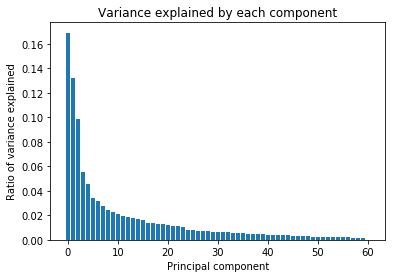

In [42]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components=30)
azdias_pca = pca_30.fit_transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
I decided to keep 30 principal components by using the PCA function, n_components and assigning it to a new variable "pca_30". I then used that variable, fit_transform, and the scaled dataframe to create the azdias_pca variable.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i, columns):
    df = pd.DataFrame(pca.components_, columns=columns)
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

pca_weight_0 = pca_weights(pca_30, 0, azdias_clean_scaled.columns)
print(pca_weight_0)

PLZ8_ANTG3               0.218760
WEALTH                   0.206620
EWDICHTE                 0.195711
FINANZ_SPARER            0.184767
ORTSGR_KLS9              0.178604
PLZ8_ANTG4               0.169673
SEMIO_REL                0.151024
PLZ8_ANTG2               0.150220
DECADE                   0.149765
SEMIO_PFLICHT            0.148054
ARBEIT                   0.145893
HH_EINKOMMEN_SCORE       0.142309
FINANZ_HAUSBAUER         0.139764
KBA05_ANTG4              0.129763
FINANZ_UNAUFFAELLIGER    0.127201
RELAT_AB                 0.124071
SEMIO_RAT                0.122062
FINANZ_ANLEGER           0.120465
MOVEMENT                 0.120066
ANZ_HAUSHALTE_AKTIV      0.112361
KBA05_ANTG3              0.111293
SEMIO_MAT                0.102652
SEMIO_TRADV              0.102268
SEMIO_FAM                0.098471
REGIOTYP                 0.077759
HEALTH_TYP               0.066343
SEMIO_KAEM               0.064932
SEMIO_KULT               0.063742
SEMIO_DOM                0.048591
KKK           

In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = pca_weights(pca_30, 1, azdias_clean_scaled.columns)
print(pca_weight_1)

ALTERSKATEGORIE_GROB     0.244276
FINANZ_VORSORGER         0.224536
SEMIO_ERL                0.212810
SEMIO_LUST               0.168550
RETOURTYP_BK_S           0.166620
FINANZ_HAUSBAUER         0.143814
PLZ8_ANTG4               0.141600
ORTSGR_KLS9              0.133502
PLZ8_ANTG3               0.129128
KBA05_ANTG4              0.106896
EWDICHTE                 0.106360
W_KEIT_KIND_HH           0.105119
HH_EINKOMMEN_SCORE       0.100973
ANZ_HAUSHALTE_AKTIV      0.096328
RELAT_AB                 0.093404
PLZ8_ANTG2               0.091214
WEALTH                   0.085512
SEMIO_KAEM               0.081421
KBA05_ANTG3              0.079533
ARBEIT                   0.078852
SEMIO_KRIT               0.071519
ANREDE_KZ                0.066292
SEMIO_DOM                0.044043
WOHNDAUER_2008           0.042921
ANZ_HH_TITEL             0.041671
FINANZ_MINIMALIST        0.038189
PLZ8_HHZ                 0.032773
MOVEMENT                 0.019614
KBA05_ANTG2              0.015067
ANZ_TITEL     

In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = pca_weights(pca_30, 2, azdias_clean_scaled.columns)
print(pca_weight_2)

SEMIO_VERT               0.346831
SEMIO_SOZ                0.297770
SEMIO_KULT               0.287809
SEMIO_FAM                0.229364
PLZ8_ANTG4               0.105612
FINANZ_MINIMALIST        0.091835
ORTSGR_KLS9              0.076732
SEMIO_MAT                0.073527
RETOURTYP_BK_S           0.072423
KBA05_ANTG4              0.061463
SEMIO_REL                0.060373
ANZ_HAUSHALTE_AKTIV      0.060161
HH_EINKOMMEN_SCORE       0.060079
GREEN_AVANTGARDE         0.056890
PLZ8_ANTG3               0.052894
KBA05_ANTG3              0.050031
RELAT_AB                 0.047359
FINANZ_VORSORGER         0.044154
PLZ8_ANTG2               0.037252
KBA05_ANTG2              0.036079
PLZ8_HHZ                 0.032918
LIFE_STAGE               0.025445
ANZ_HH_TITEL             0.022967
ANZ_PERSONEN             0.020320
ALTERSKATEGORIE_GROB     0.020104
EWDICHTE                 0.019847
W_KEIT_KIND_HH           0.015999
ARBEIT                   0.013836
ANZ_TITEL                0.010954
SEMIO_TRADV   

### Discussion 2.3: Interpret Principal Components

**First principal component**

Positive (Top 5):
- PLZ8_ANTG3 | 0.218760 | Number of 6-10 family houses in the PLZ8 region
- WEALTH | 0.206620 
- EWDICHTE | 0.195711 | Density of households per square kilometer
- FINANZ_SPARER | 0.184767 | finance - money-saver
- ORTSGR_KLS9 | 0.178604 | Size of community

Negative (Bottom 5)
- KBA05_GBZ | -0.204968 | Number of buildings in the microcell
- PLZ8_ANTG1 | -0.215893 | Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1 | -0.215984 | Number of 1-2 family houses in the microcell
- MOBI_REGIO | -0.225167 | Movement patterns
- FINANZ_MINIMALIST | -0.225897 | finance - low financial interest

We can conclude that the first principal component relates to both income and the amount of family size/households.

**Second principal component**

Positive (Top 5):
- ALTERSKATEGORIE_GROB | 0.244276 | Estimated age based on given name analysis
- FINANZ_VORSORGER | 0.224536 | Finance - be prepared
- SEMIO_ERL | 0.212810 | Personality - event-oriented
- SEMIO_LUST | 0.168550 | Personality - sensual-minded
- RETOURTYP_BK_S | 0.166620 | Return type

Negative (Bottom 5)
- SEMIO_PFLICHT | -0.219117 | Personality - dutiful
- FINANZ_UNAUFFAELLIGER | -0.220191 | Finance - inconspicuous
- FINANZ_SPARER | -0.223963 | Finance - money-saver
- SEMIO_REL | -0.232294 | Personality - religious
- DECADE | -0.234752

We can conclude that the second principal component relates to income, personality, and age.

**Third principal component**

Positive (Top 5):
- SEMIO_VERT | 0.346831 | Personality - dreamful
- SEMIO_SOZ | 0.297770 | Personality - socially-minded
- SEMIO_KULT | 0.287809 | Personality - cultural-minded
- SEMIO_FAM | 0.229364 | Personality - family-minded
- PLZ8_ANTG4 | 0.105612 | Number of 10+ family houses in the PLZ8 region

Negative (Bottom 5)
- SEMIO_ERL | -0.180054 | Personality - event-oriented
- SEMIO_KRIT | -0.309731 | Personality - critical-minded
- SEMIO_DOM | -0.319186 | Personality - dominant-minded
- ANREDE_KZ | -0.343208 | Gender
- SEMIO_KAEM | -0.345545 | Personality - combative attitude

We can conclude that the third principal component relates to personality, 10+ household size, and gender.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [45]:
# Over a number of different cluster counts...
df = pd.DataFrame()
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

# run k-means clustering on the data and...
scores = []
for i in range(1, 16):  # Test for number of clusters from 1 to 15
    score = k_mean_score(azdias_pca, i)
    scores.append(score)
    
    print("currently checked {} clusters' case. The score: {:.2f}".format(i,score))

currently checked 1 clusters' case. The score: 48497870.89
currently checked 2 clusters' case. The score: 41702813.40
currently checked 3 clusters' case. The score: 37868140.98
currently checked 4 clusters' case. The score: 35383569.62
currently checked 5 clusters' case. The score: 33523084.63
currently checked 6 clusters' case. The score: 32058912.81
currently checked 7 clusters' case. The score: 30747599.29
currently checked 8 clusters' case. The score: 29581766.89
currently checked 9 clusters' case. The score: 28739178.79
currently checked 10 clusters' case. The score: 28102389.94
currently checked 11 clusters' case. The score: 27387717.03
currently checked 12 clusters' case. The score: 26993447.15
currently checked 13 clusters' case. The score: 26387445.45
currently checked 14 clusters' case. The score: 25836444.94
currently checked 15 clusters' case. The score: 25494565.81


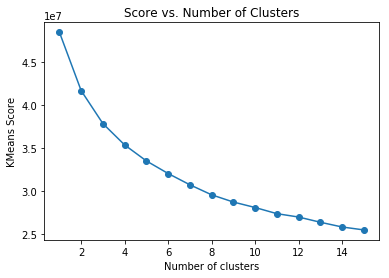

In [46]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(1, 16), scores, linestyle='-', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('KMeans Score')
plt.title('Score vs. Number of Clusters')
plt.show()

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_10 = KMeans(n_clusters=10)
model_10 = kmeans_10.fit(azdias_pca)
population_clusters = model_10.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population
Into how many clusters have you decided to segment the population?

According to the scores above, around 7 clusters the curve starts to flatten. With this information I decided to choose 10 clusters based off the median of numbers 7 to 15 which is 10.5 (rounded down).

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [48]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [49]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
1,4.0,1,5,1,5,1,3,2,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0


In [51]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 61 columns):
ALTERSKATEGORIE_GROB     191412 non-null float64
ANREDE_KZ                191652 non-null int64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               142662 non-null float64
RETOURTYP_BK_S           188439 non-null float64
SEMIO_SOZ                191652 non-null int64
SEMIO_FAM                191652 non-null int64
SEMIO_REL                191652 non-null int64
SEMIO_MAT                191652 non-null int64
SEMIO_VERT               191652 non-null int64
SEMIO_LUST               191652 non-null int64
SEMIO_ERL                191652 non-null int64
SEMIO_KULT               191652 non-n

In [52]:
#Replace NaN values
customers_clean_imputed = pd.DataFrame(imp_mf.transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

#Apply Scaling
customers_clean_scaled = SScale.fit_transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))

#Apply PCA
customers_pca = pca_30.transform(customers_clean_scaled)

In [53]:
customers_clean_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,0.888248,-0.776965,1.000000,-0.801149,0.820488,-0.847979,-0.407296,-0.680853,1.312832,-1.509629,...,-0.659268,1.824772,1.716728,-2.113864,-1.665697,-1.577416,-0.937726,-1.312832,-1.391682,0.165175
1,0.888248,-0.776965,1.000000,-0.801149,0.820488,-0.847979,0.223021,-0.680853,-0.761712,-1.509629,...,-0.659268,-0.545215,-0.499685,0.858173,-0.047489,0.061867,1.303065,0.761712,1.102193,-1.122708
2,0.888248,1.287059,1.000000,-0.801149,0.820488,-0.847979,0.853339,1.062295,1.312832,-0.273114,...,1.025601,-0.545215,-1.607892,-0.132506,-0.047489,0.061867,-0.937726,-1.312832,-0.144745,0.809117
3,0.888248,-0.776965,1.000000,-0.801149,0.820488,-0.259026,-1.037614,-0.680853,-0.761712,-0.273114,...,-0.659268,-0.545215,0.608521,-2.113864,-1.126294,-1.577416,-1.497924,0.761712,-0.768213,0.809117
4,-0.050102,-0.776965,-0.930079,-0.801149,-0.184171,0.918880,1.483656,-0.680853,-0.761712,0.963401,...,1.025601,-0.545215,-0.499685,-0.132506,-0.047489,-1.577416,0.182670,0.761712,0.478724,-1.122708


In [54]:
customers_predict = model_10.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

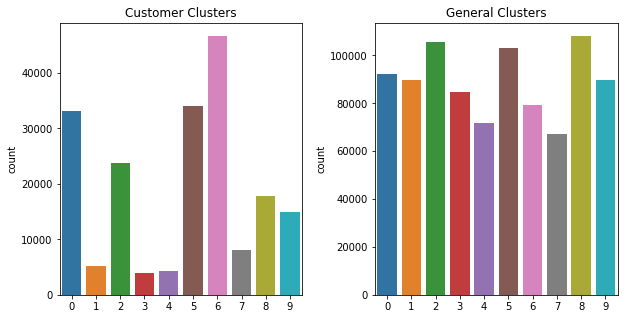

In [55]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=0.3)

sns.countplot(customers_predict, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(population_clusters, ax=axs[1])
axs[1].set_title('General Clusters')
plt.show();

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_6 = SScale.inverse_transform(pca_30.inverse_transform(model_10.cluster_centers_[6]))

In [61]:
OR_Customer = pd.Series(data = centroid_6, index = customers_clean.columns)
OR_Customer

ALTERSKATEGORIE_GROB        2.584197
ANREDE_KZ                   1.427376
FINANZ_MINIMALIST           3.915070
FINANZ_SPARER               3.128249
FINANZ_VORSORGER            3.847639
FINANZ_ANLEGER              4.590930
FINANZ_UNAUFFAELLIGER       4.885372
FINANZ_HAUSBAUER            2.633920
GREEN_AVANTGARDE            0.132088
HEALTH_TYP                  2.961021
RETOURTYP_BK_S              3.534097
SEMIO_SOZ                   1.994662
SEMIO_FAM                   5.772845
SEMIO_REL                   6.696247
SEMIO_MAT                   4.896949
SEMIO_VERT                  1.036146
SEMIO_LUST                  5.722290
SEMIO_ERL                   3.073669
SEMIO_KULT                  2.848602
SEMIO_RAT                   3.335900
SEMIO_KRIT                  7.183027
SEMIO_DOM                   5.644924
SEMIO_KAEM                  5.693229
SEMIO_PFLICHT               4.249889
SEMIO_TRADV                 2.480299
ANZ_PERSONEN                1.270790
ANZ_TITEL                   0.008026
H

In [62]:
centroid_3 = SScale.inverse_transform(pca_30.inverse_transform(model_10.cluster_centers_[3]))

In [63]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
UR_Customer = pd.Series(data = centroid_3, index = customers_clean.columns)
UR_Customer

ALTERSKATEGORIE_GROB        1.937648
ANREDE_KZ                   1.835836
FINANZ_MINIMALIST           2.482316
FINANZ_SPARER               3.350633
FINANZ_VORSORGER            3.310908
FINANZ_ANLEGER              3.649075
FINANZ_UNAUFFAELLIGER       3.513265
FINANZ_HAUSBAUER            3.728965
GREEN_AVANTGARDE            0.174806
HEALTH_TYP                  2.273308
RETOURTYP_BK_S              3.165843
SEMIO_SOZ                   3.091500
SEMIO_FAM                   4.157105
SEMIO_REL                   5.327523
SEMIO_MAT                   4.749580
SEMIO_VERT                  2.111771
SEMIO_LUST                  4.575950
SEMIO_ERL                   4.284002
SEMIO_KULT                  3.760976
SEMIO_RAT                   4.991515
SEMIO_KRIT                  5.492157
SEMIO_DOM                   5.821743
SEMIO_KAEM                  5.892386
SEMIO_PFLICHT               5.150181
SEMIO_TRADV                 4.240757
ANZ_PERSONEN                1.698903
ANZ_TITEL                   0.012120
H

### Discussion 3.3: Compare Customer Data to Demographics Data
Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

With both the overrepresented and underrepresented variables the `ALTERSKATEGORIE_GROB` column is at the top of the list.

ALTERSKATEGORIE_GROB = Estimated age based on given name analysis
- 1: < 30 years old
- 2: 30 - 45 years old
- 3: 46 - 60 years old
- 4: > 60 years old
- 9: uniformly distributed

**Overrepresented** :
The value for ALTERSKATEGORIE_GROB in the overrepresented is 2.584197 which equates to individuals 30 to 45 years old.

**Underrepresented** :
The value for ALTERSKATEGORIE_GROB in the underrepresented variable is 1.937648 which equates to individuals younger than 30.

One could conclude that the company spends more time advertising and focusing on older individuals rather than younger individuals.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.